# Сборный проект №1

## Введение

<div style="border:solid Chocolate 2px; padding: 40px">

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
    
<h3> Цель: <a class="tocSkip"> </h3> 

- выявить закономерности, определяющие успешность игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
    
<h3> Задачи: <a class="tocSkip"> </h3> 
    
- Открыть файл с данными;
- Подготовить данные;
- Провести исследовательский анализ данных;
- Составить портре пользователя каждого региона;
- Проверить гипотезы: 
    - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
    - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные;
- Написать общий вывод;

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


<div class="alert alert-info">
<h3> Комментарий <a class="tocSkip"></h3>

Загрузили данные. Видим много пропусков в разныл столбцах, неправильные форматы данныз. Займемся этим. 
</div>

## Предобработка

In [4]:
#Ищим дубликаты
data.duplicated().sum()

0

In [5]:
#приводим столбцы в нижний регистр
data.columns = data.columns.str.lower()

In [6]:
#считаем пропуски по каждому столбцу
data.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [7]:
data.rating = data.rating.fillna('NAN')

<div class="alert alert-info">
<h3> Комментарий <a class="tocSkip"></h3>

Пытаемся выяснить откуда пропуски в годе выпуска. 
Очевидной причины не видно. Попуски в разных патформах, разных жанрах и разных годах выпуска. Удалять не будем, эти даные нам понадобятся для дальгейшего анализа. 
    
</div>

In [8]:
data.year_of_release = data.year_of_release.astype(float).astype('Int64')
#data.year_of_release = data.year_of_release.fillna(0)
#data.query('year_of_release == 0').head(15)





<div class="alert alert-info">
<h3> Комментарий <a class="tocSkip"></h3>

В user_score есть TBD (to be determined)
Видимо эти оценки собираются дополнить позже. Пока меняем их на NaN, чтобы можно было перевести в float 
    
</div>

In [9]:
data.user_score = data.user_score.replace("tbd", np.NaN)
data.user_score = data.user_score.astype(float).astype('float64')


In [10]:
data.rating.value_counts()

NAN     6766
E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

In [11]:
data = data[(data['rating'] != 'EC') & (data['rating'] != 'RP') & (data['rating'] != 'AO')]

In [12]:
#теперь все хорошо
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16703 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16701 non-null  object 
 1   platform         16703 non-null  object 
 2   year_of_release  16436 non-null  Int64  
 3   genre            16701 non-null  object 
 4   na_sales         16703 non-null  float64
 5   eu_sales         16703 non-null  float64
 6   jp_sales         16703 non-null  float64
 7   other_sales      16703 non-null  float64
 8   critic_score     8133 non-null   float64
 9   user_score       7586 non-null   float64
 10  rating           16703 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


<div class="alert alert-info">
<h3> Комментарий <a class="tocSkip"></h3>

Предобработали данные. Дубликатов нет. есть пропуски в некоторых столбцах: year_of_realease, critic_score, user_score - удалять или заполнять пропуски не будем. Слишком много пропусков, чтобы просто удалть столцы. А заполянть средним или медианными знаениями будет неправильно в данном случае. 
    
А вот rating мы заполним на 'NAN', эти данные нам понадобятся потом при ислледовании. 
</div>

In [13]:
#Создаем столбец с общими продажами
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

## Исследовательский анализ данных

### Тенденции выпуска игр по годам

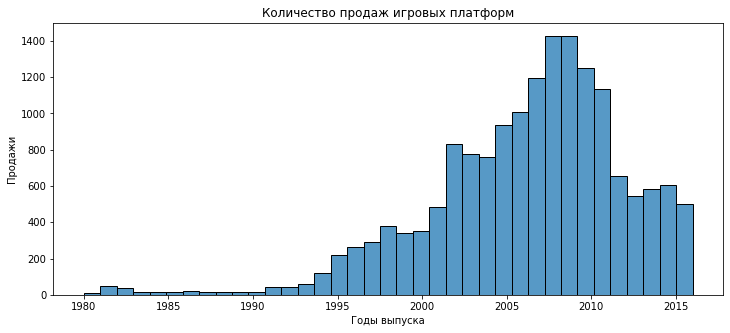

In [14]:
plt.figure(figsize=(12,5))
sns.histplot (data=data.year_of_release, bins=37)
plt.title('Количество продаж игровых платформ')
plt.xlabel('Годы выпуска')
plt.ylabel('Продажи')
plt.show()

<div class="alert alert-info">
<h3> Комментарий <a class="tocSkip"></h3>

Количество выпускаемых игр начало сильно рости с 90-х годов, в 2011 году набюдается резкий спад производста. Скорее всего, это связано с активным развитием смартфонов
    
</div>

### Самые популярные платформы

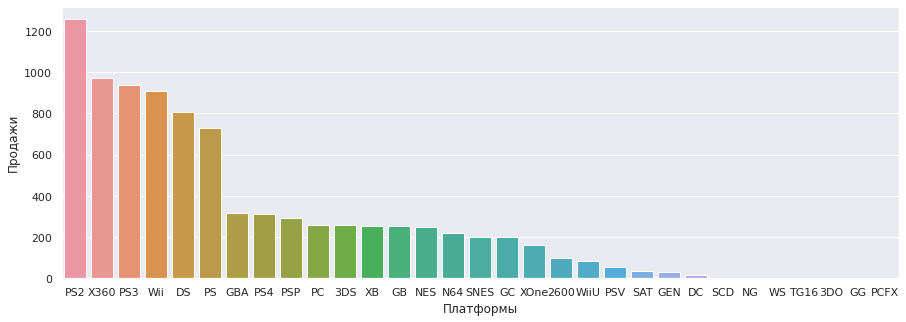

In [15]:
platform_on_sales = data.pivot_table(
    index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=platform_on_sales.index,y=platform_on_sales.total_sales)
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()

<div class="alert alert-info">
<h3> Комментарий <a class="tocSkip"></h3>

5ка лидеров: 
- PS2;
- X360;
- PS3;
- Wii;
- Ds;
    
</div>

### Распределение по годам среди платформ с наибольшими продажами.  Определение актуального периода.


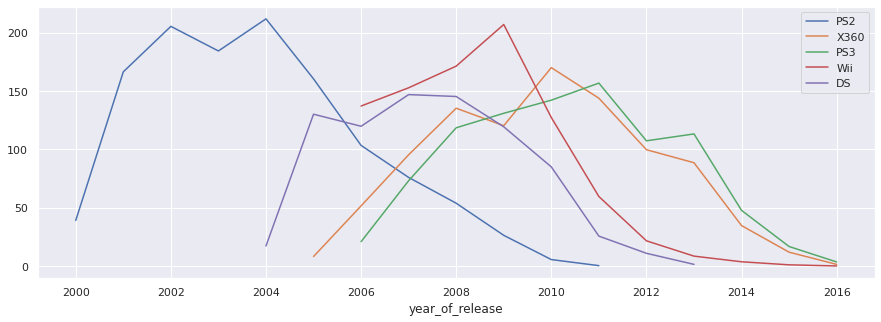

In [16]:
PS2 = data.query('platform =="PS2"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
X360 = data.query('platform =="X360"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
PS3 = data.query('platform =="PS3"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
Wii = data.query('platform =="Wii"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
DS = data.query('platform =="DS"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')


top_platforms = (
    PS2.merge(X360, how='outer', on='year_of_release')
    .merge(PS3, how='outer', on='year_of_release')
    .merge(Wii, how='outer', on='year_of_release')
    .merge(DS, how='outer', on='year_of_release')
)

top_platforms = top_platforms.set_axis(['PS2', 'X360', 'PS3', 'Wii', 'DS'], axis = 'columns')
top_platforms.query('year_of_release >= 1995').plot(figsize=(15, 5))
plt.show()


<div class="alert alert-info">
<h3> Комментарий <a class="tocSkip"></h3>

В среднем платформа существует 10-12 лет. 
    
Судя по графику, мы ограничимся периодом с 2005 года. 
    
Видно, что все платформы к 2016 году практически перестали продаваться. 
    
</div>

### Популярные платформы за актуальный период

In [17]:
data=data.query('year_of_release >= 2012')

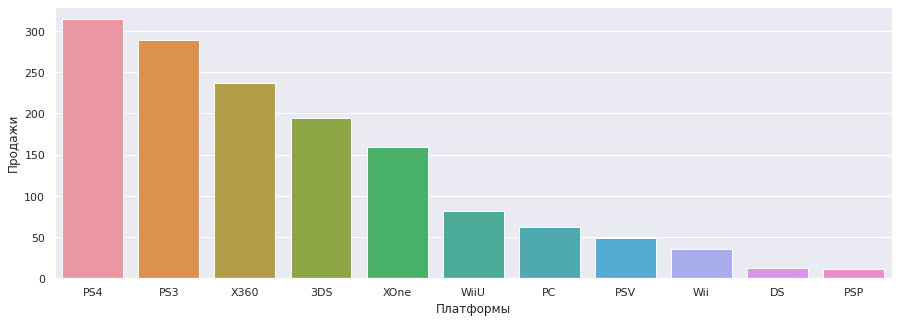

In [18]:
platform_on_sales = data.pivot_table(
    index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=platform_on_sales.index,y=platform_on_sales.total_sales)
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()

<div class="alert alert-info">
<h3> Комментарий <a class="tocSkip"></h3>

С 2012 года пятерка фаворитов немного изменилась,
    
Теперь пятерка фаворитов выглядит так PS4, PS3, X360, 3DS, XOne.
    
</div>

### График «ящик с усами» по глобальным продажам игр в разбивке по платформам

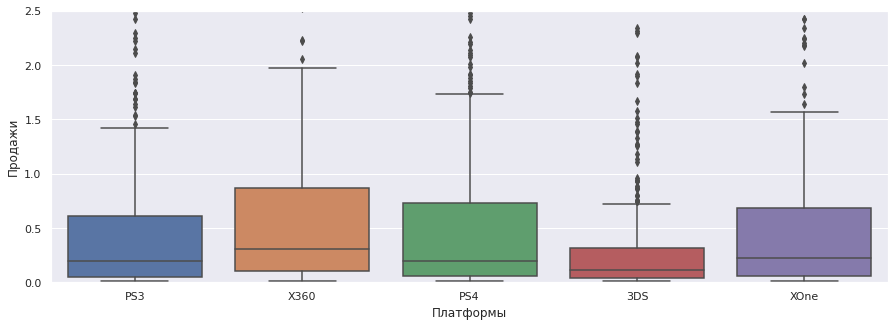

In [19]:
top_platforms = data[data['platform'].isin(['PS4','PS3','X360','3DS','XOne'])]
plt.figure(figsize=(15,5))
plt.ylim([0,2.5])
sns.boxplot(data=top_platforms, x='platform', y='total_sales')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()

<div class="alert alert-info">
<h3> Комментарий<a class="tocSkip"></h3>


    
Медиана продаж разная, но находится примерно на одном уровне , разница не значительная. 

Больше продаж у X360. 
    
Дальше примерно одинаково продаются PS3, PS4 и XOne. 
    
Хуже всего дела обстоят у 3DS
</div>

### Влияние  отзывов пользователей и критокво на продажи внутри самой популярной платформы


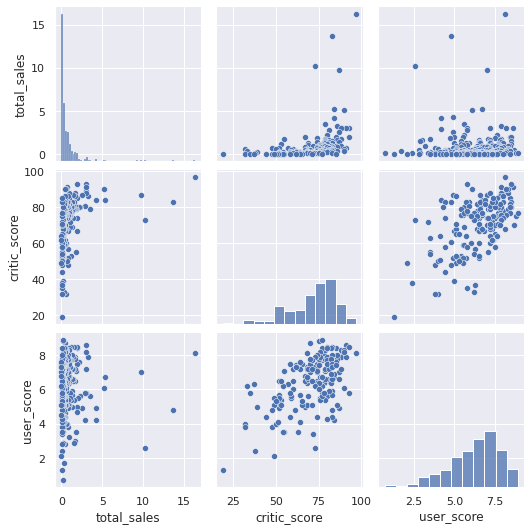

In [20]:
sns.pairplot(data[data['platform'] == "X360"][['total_sales', 'critic_score', 'user_score']])
plt.show()

In [21]:
data[data.platform == "X360"][['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.360573,0.006164
critic_score,0.360573,1.000000,0.557352
user_score,0.006164,0.557352,1.000000


<div class="alert alert-info">
<h3> Комментарий<a class="tocSkip"></h3>

Очевидно, чем больше оценка как критиков, так пользователей, тем больше продаж. Хотя есть некоторые "выбросы" у игр с низкими оценками пользователей. Может быть,  это те игры, которые настолько плохи, что нужно в них погирать? :)
Посмотрим на другие плафтормы
</div>

### Зависимость отзывов и продаж других платформ

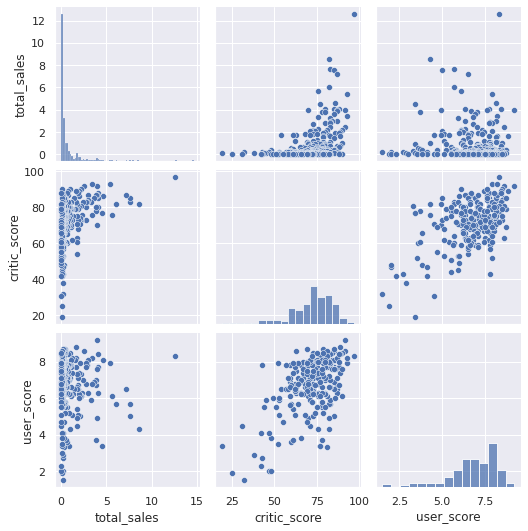

In [22]:
sns.pairplot(data[data['platform'] == "PS4"][['total_sales', 'critic_score', 'user_score']])
plt.show()

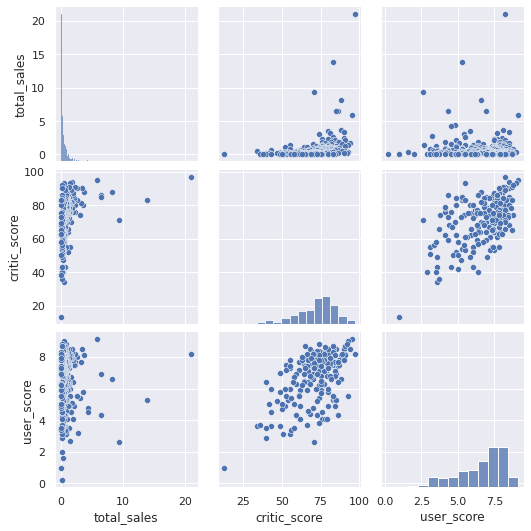

In [23]:
sns.pairplot(data[data['platform'] == "PS3"][['total_sales', 'critic_score', 'user_score']])
plt.show()

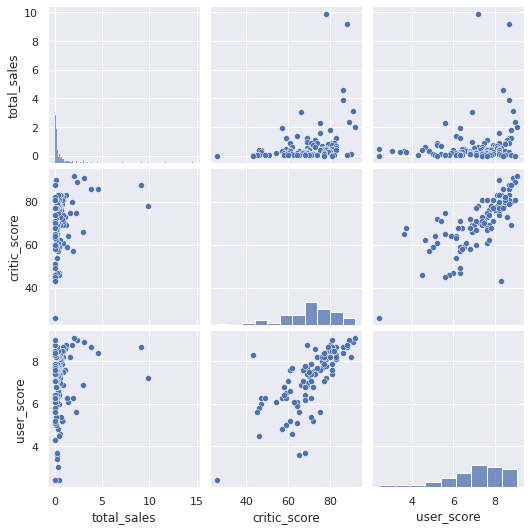

In [24]:
sns.pairplot(data[data['platform'] == "3DS"][['total_sales', 'critic_score', 'user_score']])
plt.show()

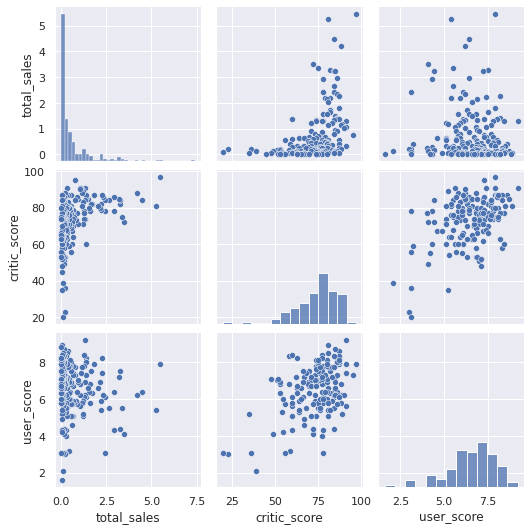

In [25]:
sns.pairplot(data[data['platform'] == "XOne"][['total_sales', 'critic_score', 'user_score']])
plt.show()

<div class="alert alert-info">
<h3> Комментарий<a class="tocSkip"></h3>

Видно, что в других платформах зависимость отзывов примерно соотвествует зависимости в самой популярной платформе. Значительных различий нет.
    
    
Очевидно, что чем больше оценка критиков и пользователей, тем больше продажи. Это отлично видно на примере всех платформ
    
    
</div>

### Распределение игр по жанрам

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   genre        12 non-null     object 
 1   total_sales  12 non-null     float64
dtypes: float64(1), object(1)
memory usage: 320.0+ bytes


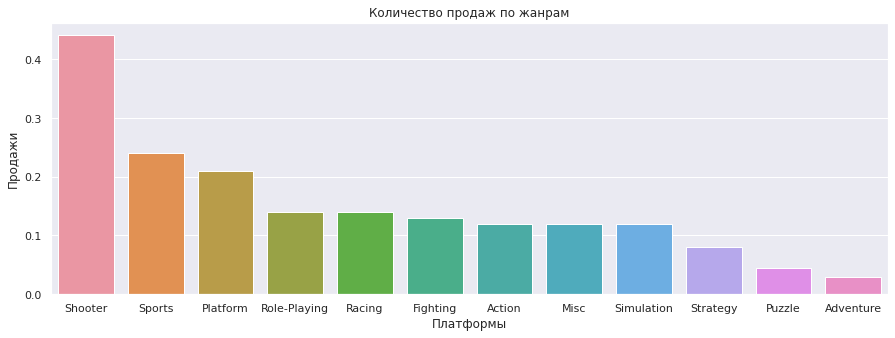

In [26]:
dis_genre = data.pivot_table(
    index='genre', values='total_sales', aggfunc='median').sort_values(by='total_sales', ascending=False).reset_index()
dis_genre.info()


sns.barplot(x=dis_genre['genre'], y=dis_genre['total_sales'])
plt.title('Количество продаж по жанрам')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()

<div class="alert alert-info">
<h3> Комментарий <a class="tocSkip"></h3>

Глядя на медиану продаж по жанрам, мы можем увидеть пятерку лидеров: Shooter, Sports, Platform, Role-Playin, Racing
</div>

### Портерт пользователя каждого региона.  

In [27]:
regions = data\
            .pivot_table(['na_sales','eu_sales','jp_sales','other_sales','total_sales'], ['platform'], aggfunc='sum')\
            .sort_values(by='na_sales', ascending=False)

regions

,eu_sales,jp_sales,na_sales,other_sales,total_sales
platform,,,,,
X360,74.52,1.57,140.05,20.40,236.54
PS4,141.09,15.96,108.74,48.35,314.14
PS3,106.86,35.29,103.38,43.26,288.79
XOne,51.59,0.34,93.12,14.27,159.32
3DS,42.64,87.79,55.31,8.87,194.61
WiiU,25.13,13.01,38.10,5.95,82.19
PC,37.76,0.00,19.12,5.77,62.65
Wii,11.92,3.39,17.45,2.61,35.37
PSV,11.36,21.04,10.98,5.80,49.18


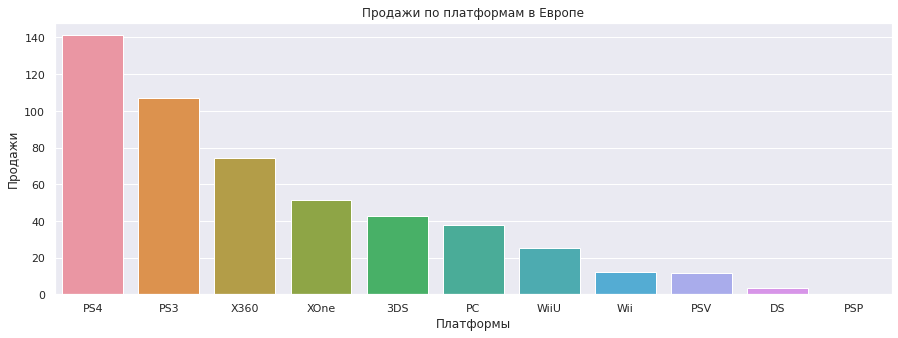

In [28]:
eutop=data.pivot_table(
    index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(15)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=eutop.index,y=eutop.eu_sales)
plt.title('Продажи по платформам в Европе')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()

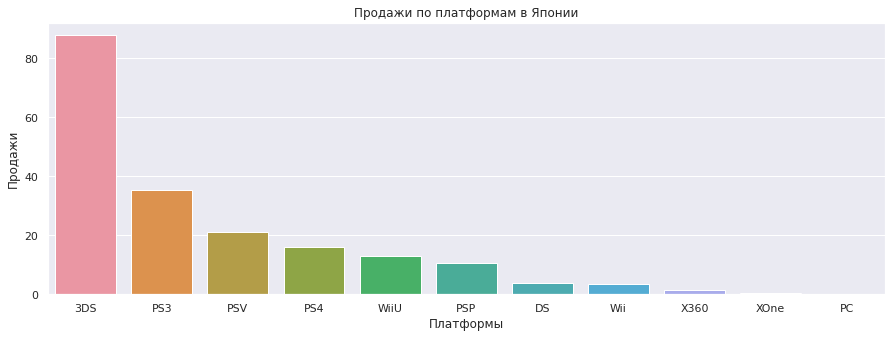

In [29]:
jptop=data.pivot_table(
    index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(15)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=jptop.index,y=jptop.jp_sales)
plt.title('Продажи по платформам в Японии')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()

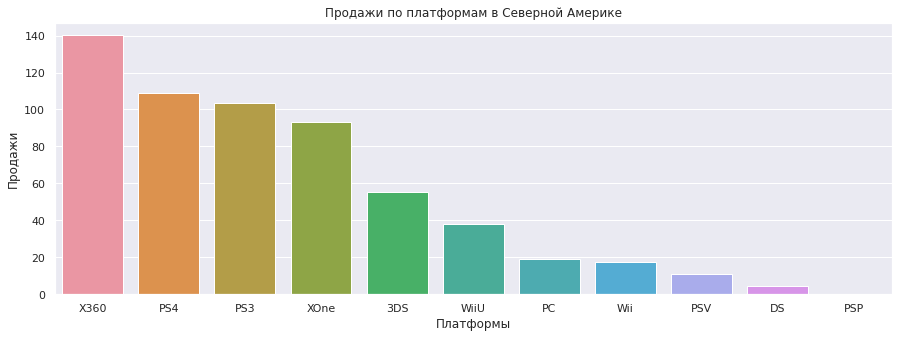

In [30]:
natop=data.pivot_table(
    index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(15)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=natop.index,y=natop.na_sales)
plt.title('Продажи по платформам в Северной Америке')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()

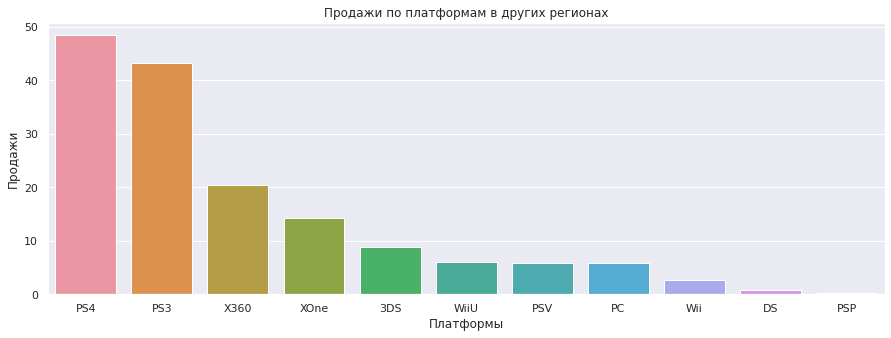

In [31]:
othertop=data.pivot_table(
    index='platform', values='other_sales', aggfunc='sum').sort_values(by='other_sales', ascending=False).head(15)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=othertop.index,y=othertop.other_sales)
plt.title('Продажи по платформам в других регионах')
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()

In [32]:
genre = data\
            .pivot_table(['na_sales','eu_sales','jp_sales','other_sales','total_sales'], ['genre'], aggfunc='sum')\
            .sort_values(by='na_sales', ascending=False)

genre

,eu_sales,jp_sales,na_sales,other_sales,total_sales
genre,,,,,
Action,159.34,52.80,177.84,51.14,441.12
Shooter,113.47,9.23,144.77,37.26,304.73
Sports,69.09,8.01,81.53,22.44,181.07
Role-Playing,48.53,65.44,64.00,14.83,192.80
Misc,26.32,12.86,38.19,7.67,85.04
Platform,21.41,8.63,25.38,5.58,61.00
Fighting,10.79,9.44,19.79,4.47,44.49
Racing,27.29,2.50,17.22,6.49,53.50
Adventure,9.46,8.24,8.92,2.81,29.43


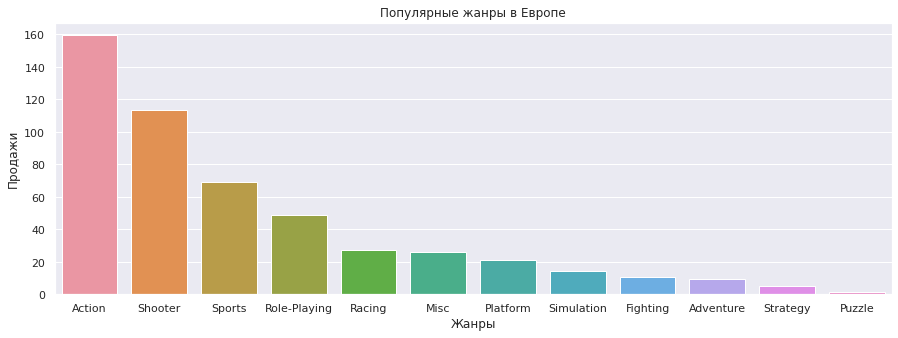

In [33]:
eu_genre_top=data.pivot_table(
    index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=eu_genre_top.index,y=eu_genre_top.eu_sales)
plt.title('Популярные жанры в Европе')
plt.xlabel('Жанры')
plt.ylabel('Продажи')
plt.show()

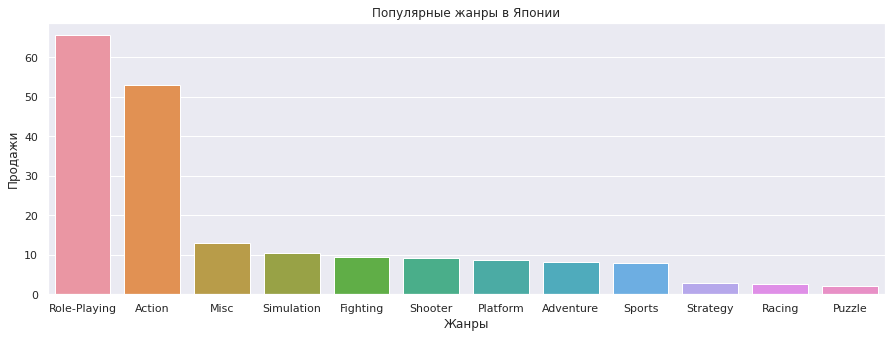

In [34]:
jp_genre_top=data.pivot_table(
    index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=jp_genre_top.index,y=jp_genre_top.jp_sales)
plt.title('Популярные жанры в Японии')
plt.xlabel('Жанры')
plt.ylabel('Продажи')
plt.show()

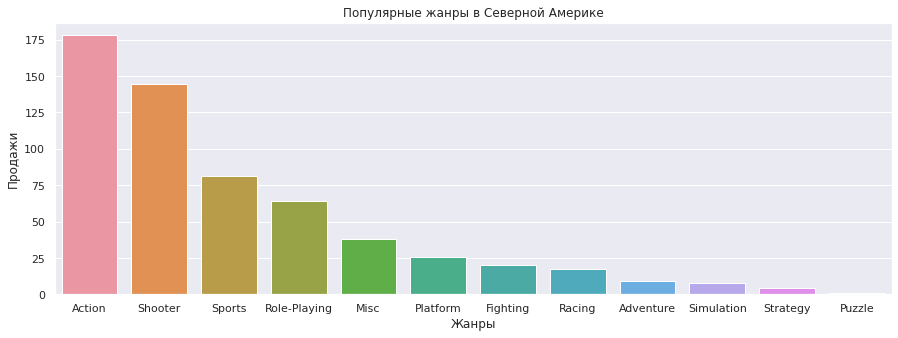

In [35]:
na_genre_top=data.pivot_table(
    index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=na_genre_top.index,y=na_genre_top.na_sales)
plt.title('Популярные жанры в Северной Америке')
plt.xlabel('Жанры')
plt.ylabel('Продажи')
plt.show()

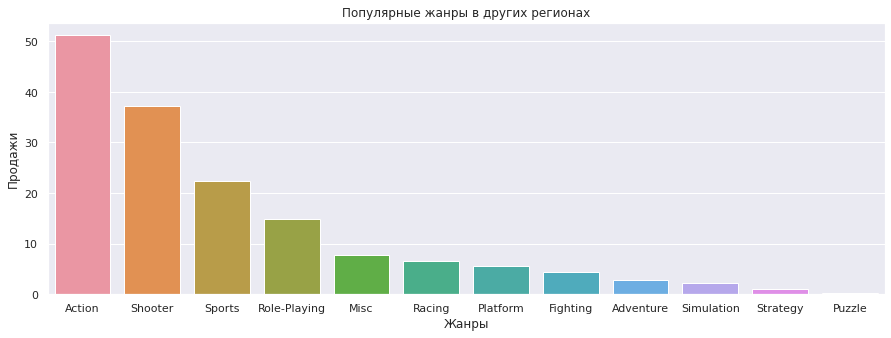

In [36]:
other_genre_top=data.pivot_table(
    index='genre', values='other_sales', aggfunc='sum').sort_values(by='other_sales', ascending=False)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=other_genre_top.index,y=other_genre_top.other_sales)
plt.title('Популярные жанры в других регионах')
plt.xlabel('Жанры')
plt.ylabel('Продажи')
plt.show()

<div class="alert alert-info">
<h3> Комментарий <a class="tocSkip"></h3>

Популярные платформы: 
- Европа. PS4, PS3, X360, XOne, 3DS;
- Япония. 3DS, PS3, PSV, PS4, WiiU;
- Северная Америка. X360, PS4, PS3, XOne, 3DS;
- Другие регионы. PS4, PS3, X360, XOne, 3DS.

Популярные жанры: 
- Европа. Action, Shooter, Sport,  Role-playing, Racing;
- Япония. Role-playing, Action, Misc, Simulation, Fighting;
- Северная Америка. Action, Shooter, Sport, Role-playing, Misc;
- Другие регоины. Action, Shooter, Sport, Role-playing, Misc;


В целом везде популярны примерно одни и те же платформы и жанры. Только в Япониии немного другое распределение.
</div>



### Влияние рейтинга на продажи. 

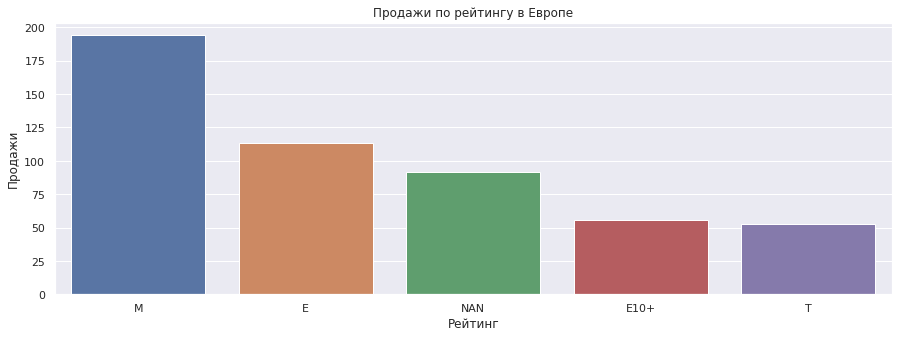

In [37]:
rating_eu=data.pivot_table(
    index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=rating_eu.index,y=rating_eu.eu_sales)

plt.title('Продажи по рейтингу в Европе')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи')
plt.show()

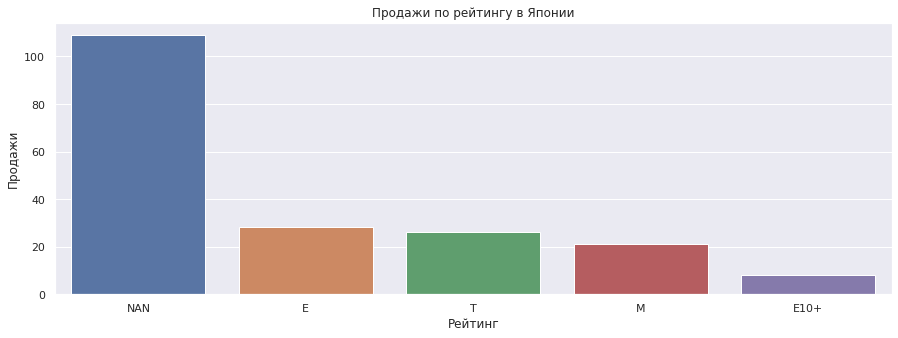

In [38]:
rating_jp=data.pivot_table(
    index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=rating_jp.index,y=rating_jp.jp_sales)
plt.title('Продажи по рейтингу в Японии')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи')
plt.show()

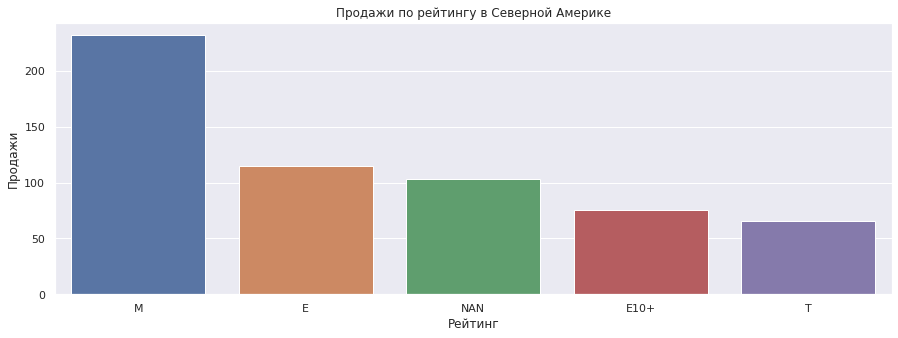

In [39]:
rating_na=data.pivot_table(
    index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=rating_na.index,y=rating_na.na_sales)
plt.title('Продажи по рейтингу в Северной Америке')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи')
plt.show()

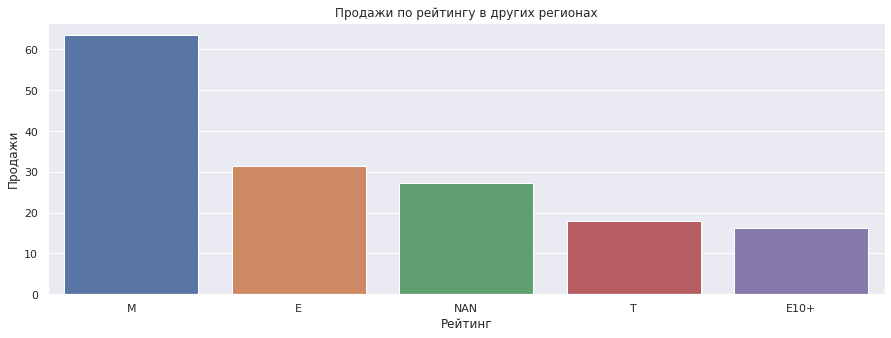

In [40]:
rating_other=data.pivot_table(
    index='rating', values='other_sales', aggfunc='sum').sort_values(by='other_sales', ascending=False)

sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=rating_other.index,y=rating_other.other_sales)
plt.title('Продажи по рейтингу в других регионах')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи')
plt.show()

<div class="alert alert-info">
<h3> Комментарий <a class="tocSkip"></h3>

В Европе и Северной Америке рейтинг сильно влияет на продаже. там на первом месте категория "Е".
    
А Японцы снова отличаются. Игры без рейтина от ESRB занимают первое место и находятся в большом отрыве от остальных игр с оценками. Видимо, ESRB не оценивает игры, популярные и выпускаемые в Японии. 
</div>

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые:
- Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; 
- Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC различаются;

In [41]:
xone_test = data[(data['platform']=='XOne') & (data['user_score'] > 0)]['user_score']
pc_test = data[(data['platform']=='PC') & (data['user_score'] > 0)]['user_score']

alpha = .05

results = st.ttest_ind(xone_test.dropna(), pc_test.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")



p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


### Средние пользовательские рейтинги жанров Action  и Sports разные:

- Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports одинаковые;
- Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports различаются;

In [42]:
genre_action_hyp = data[(data['genre']=='Action') & (data['user_score'] > 0)]['user_score']
genre_sports_hyp = data[(data['genre']=='Sports') & (data['user_score'] > 0)]['user_score']

alpha = .05

results = st.ttest_ind(genre_action_hyp.dropna(), genre_sports_hyp.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


## Общие выводы

<div style="border:solid Chocolate 2px; padding: 40px">
    
- Мы подготовили данные. Привели к нужному регистру, убрали пропуски, поменяли тип ячеек там, где это нужно было;


- Определили, что резкий рост игр начался в 90х, а к концу нудевых произошел резкий спад разработок;


- Самые популярные платформы: PS4, PS3, X360, 3DS, XOne.


- В среднем платформы появляются и исчезают за 10-12 лет;


- Выяснили, что чем больше рейтинг критиков и пользователей, тем больше продаж. Хотя и есть забваные исключения, где рейтинг маленький, но большие продажи; 


- Самые популярные жанры: Shooter, Sports, Platform, Role-Playin, Racing;


- Составили портрет пользователей по регионам. В целом все регионы похожи, только Япония заметно отличается по поведению: 
  - Популярные платформы: 
    - Европа. PS4, PS3, X360, XOne, 3DS;
    - Япония. 3DS, PS3, PSV, PS4, WiiU;
    - Северная Америка. X360, PS4, PS3, XOne, 3DS;
    - Другие регионы. PS4, PS3, X360, XOne, 3DS.
  - Популярные жанры: 
    - Европа. Action, Shooter, Sport,  Role-playing, Racing;
    - Япония. Role-playing, Action, Misc, Simulation, Fighting;
    - Северная Америка. Action, Shooter, Sport, Role-playing, Misc;
    - Другие регоины. Action, Shooter, Sport, Role-playing, Misc;
    
    
- Проверка гипотез:
  - Гипотеза №1. Не получилось отвергнуть нулевую гипотезу. 
  - Гипотеза №2. Нулевая гипотеза отвергнута. 

